In [1]:
from datasets import DynamicsDataset
from torch.utils.data import DataLoader

## Generate Dataset

In [6]:
dataset = DynamicsDataset(
    size=100,                # number of trajectories
    T=2,                     # total time
    sample_rate=0.01,        # time step
    params={'rho': 28},      # pass custom Lorenz63 parameters here
    dyn_sys_name='Lorenz63', # system name
    input_inds=[0],          # which variable(s) to use as input
    output_inds=[1,2],       # which variable(s) to use as output
    test=False
)

dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [7]:
for x, y, times_x, times_y in dataloader:
    print("Input batch shape:", x.shape)
    print("Output batch shape:", y.shape)
    print("Times shape:", times_x.shape)
    break  # Remove break to iterate through all batches

Input batch shape: torch.Size([16, 200, 1])
Output batch shape: torch.Size([16, 200, 2])
Times shape: torch.Size([16, 200, 1])


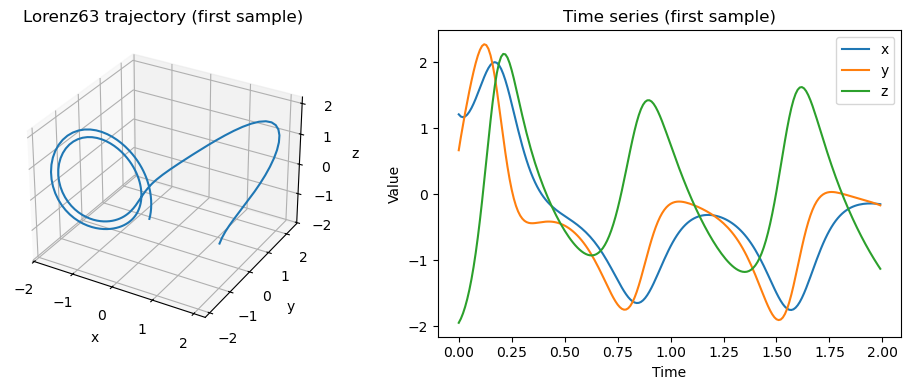

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# Get the full normalized data from the dataset
# x: (n_traj, seq_len, input_dim), y: (n_traj, seq_len, output_dim)
x = dataset.x      # shape: (n_traj, seq_len, input_dim)
y = dataset.y      # shape: (n_traj, seq_len, output_dim)
t = dataset.times_x.squeeze(-1)  # shape: (seq_len,)

# For Lorenz63, if input_inds=[0] and output_inds=[1,2], you can reconstruct (x, y, z)
# x[:, :, 0] is x, y[:, :, 0] is y, y[:, :, 1] is z

# Take the first trajectory
x1 = x[0, :, 0].cpu().numpy()      # x
y1 = y[0, :, 0].cpu().numpy()      # y
z1 = y[0, :, 1].cpu().numpy()      # z

# Plot
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(121, projection='3d')
ax.plot(x1, y1, z1)
ax.set_title('Lorenz63 trajectory (first sample)')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax2 = fig.add_subplot(122)
ax2.plot(t, x1, label='x')
ax2.plot(t, y1, label='y')
ax2.plot(t, z1, label='z')
ax2.set_title('Time series (first sample)')
ax2.set_xlabel('Time')
ax2.set_ylabel('Value')
ax2.legend()

plt.tight_layout()
plt.show()

## Set up Transformer

In [9]:
# Import deep learning modules
import torch
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor, EarlyStopping
import wandb
from pytorch_lightning.tuner import Tuner

# Import custom modules
from datasets import MetaDataModule
from models.TNO.TNO_lightning import SimpleEncoderModule

In [10]:
model = SimpleEncoderModule(
    input_dim=1,           # matches input_inds=[0]
    output_dim=2,          # matches output_inds=[1,2]
    domain_dim=1,
    d_model=32,            # or 128, etc.
    nhead=4,               # or 8, etc.
    num_layers=4,          # or 6, etc.
    activation='gelu',     # or 'gelu'
    dim_feedforward=128,   # or 2048, etc.
    dropout=0.1,
    learning_rate=1e-3,
)

In [12]:
# Set up callbacks (optional but recommended)
lr_monitor = LearningRateMonitor(logging_interval='epoch')
early_stop = EarlyStopping(monitor='loss/val/mse', patience=10, mode="min")

# Set up PyTorch Lightning Trainer (no WandbLogger)
trainer = Trainer(
    max_epochs=100,
    callbacks=[lr_monitor, early_stop],
    accelerator="auto",  # use GPU if available
)

# Fit the model using the dataloader
trainer.fit(model, train_dataloaders=dataloader, val_dataloaders=dataloader)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | SimpleEncoder | 51.0 K | train
------------------------------------------------
51.0 K    Trainable params
4         Non-trainable params
51.0 K    Total params
0.204     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 7/7 [00:01<00:00,  4.17it/s, v_num=1, loss/val/mse=0.565, loss/val/sup=2.770, loss/val/rel_L2=0.724, loss/train/mse=0.656, loss/train/sup=2.970, loss/train/rel_L2=0.782]

MisconfigurationException: ReduceLROnPlateau conditioned on metric train_loss which is not available. Available metrics are: ['lr-Adam', 'loss/val/mse', 'loss/val/sup', 'loss/val/rel_L2', 'loss/train/mse', 'loss/train/sup', 'loss/train/rel_L2', 'grad_norm/afterBackward/model_encoder_layers_0_self_attn_W_q_weight', 'grad_norm/afterBackward/model_encoder_layers_0_self_attn_W_q_bias', 'grad_norm/afterBackward/model_encoder_layers_0_self_attn_W_k_weight', 'grad_norm/afterBackward/model_encoder_layers_0_self_attn_W_k_bias', 'grad_norm/afterBackward/model_encoder_layers_0_self_attn_W_v_weight', 'grad_norm/afterBackward/model_encoder_layers_0_self_attn_W_v_bias', 'grad_norm/afterBackward/model_encoder_layers_0_self_attn_W_o_weight', 'grad_norm/afterBackward/model_encoder_layers_0_self_attn_W_o_bias', 'grad_norm/afterBackward/model_encoder_layers_0_feed_forward_fc1_weight', 'grad_norm/afterBackward/model_encoder_layers_0_feed_forward_fc1_bias', 'grad_norm/afterBackward/model_encoder_layers_0_feed_forward_fc2_weight', 'grad_norm/afterBackward/model_encoder_layers_0_feed_forward_fc2_bias', 'grad_norm/afterBackward/model_encoder_layers_0_norm1_weight', 'grad_norm/afterBackward/model_encoder_layers_0_norm1_bias', 'grad_norm/afterBackward/model_encoder_layers_0_norm2_weight', 'grad_norm/afterBackward/model_encoder_layers_0_norm2_bias', 'grad_norm/afterBackward/model_encoder_layers_1_self_attn_W_q_weight', 'grad_norm/afterBackward/model_encoder_layers_1_self_attn_W_q_bias', 'grad_norm/afterBackward/model_encoder_layers_1_self_attn_W_k_weight', 'grad_norm/afterBackward/model_encoder_layers_1_self_attn_W_k_bias', 'grad_norm/afterBackward/model_encoder_layers_1_self_attn_W_v_weight', 'grad_norm/afterBackward/model_encoder_layers_1_self_attn_W_v_bias', 'grad_norm/afterBackward/model_encoder_layers_1_self_attn_W_o_weight', 'grad_norm/afterBackward/model_encoder_layers_1_self_attn_W_o_bias', 'grad_norm/afterBackward/model_encoder_layers_1_feed_forward_fc1_weight', 'grad_norm/afterBackward/model_encoder_layers_1_feed_forward_fc1_bias', 'grad_norm/afterBackward/model_encoder_layers_1_feed_forward_fc2_weight', 'grad_norm/afterBackward/model_encoder_layers_1_feed_forward_fc2_bias', 'grad_norm/afterBackward/model_encoder_layers_1_norm1_weight', 'grad_norm/afterBackward/model_encoder_layers_1_norm1_bias', 'grad_norm/afterBackward/model_encoder_layers_1_norm2_weight', 'grad_norm/afterBackward/model_encoder_layers_1_norm2_bias', 'grad_norm/afterBackward/model_encoder_layers_2_self_attn_W_q_weight', 'grad_norm/afterBackward/model_encoder_layers_2_self_attn_W_q_bias', 'grad_norm/afterBackward/model_encoder_layers_2_self_attn_W_k_weight', 'grad_norm/afterBackward/model_encoder_layers_2_self_attn_W_k_bias', 'grad_norm/afterBackward/model_encoder_layers_2_self_attn_W_v_weight', 'grad_norm/afterBackward/model_encoder_layers_2_self_attn_W_v_bias', 'grad_norm/afterBackward/model_encoder_layers_2_self_attn_W_o_weight', 'grad_norm/afterBackward/model_encoder_layers_2_self_attn_W_o_bias', 'grad_norm/afterBackward/model_encoder_layers_2_feed_forward_fc1_weight', 'grad_norm/afterBackward/model_encoder_layers_2_feed_forward_fc1_bias', 'grad_norm/afterBackward/model_encoder_layers_2_feed_forward_fc2_weight', 'grad_norm/afterBackward/model_encoder_layers_2_feed_forward_fc2_bias', 'grad_norm/afterBackward/model_encoder_layers_2_norm1_weight', 'grad_norm/afterBackward/model_encoder_layers_2_norm1_bias', 'grad_norm/afterBackward/model_encoder_layers_2_norm2_weight', 'grad_norm/afterBackward/model_encoder_layers_2_norm2_bias', 'grad_norm/afterBackward/model_encoder_layers_3_self_attn_W_q_weight', 'grad_norm/afterBackward/model_encoder_layers_3_self_attn_W_q_bias', 'grad_norm/afterBackward/model_encoder_layers_3_self_attn_W_k_weight', 'grad_norm/afterBackward/model_encoder_layers_3_self_attn_W_k_bias', 'grad_norm/afterBackward/model_encoder_layers_3_self_attn_W_v_weight', 'grad_norm/afterBackward/model_encoder_layers_3_self_attn_W_v_bias', 'grad_norm/afterBackward/model_encoder_layers_3_self_attn_W_o_weight', 'grad_norm/afterBackward/model_encoder_layers_3_self_attn_W_o_bias', 'grad_norm/afterBackward/model_encoder_layers_3_feed_forward_fc1_weight', 'grad_norm/afterBackward/model_encoder_layers_3_feed_forward_fc1_bias', 'grad_norm/afterBackward/model_encoder_layers_3_feed_forward_fc2_weight', 'grad_norm/afterBackward/model_encoder_layers_3_feed_forward_fc2_bias', 'grad_norm/afterBackward/model_encoder_layers_3_norm1_weight', 'grad_norm/afterBackward/model_encoder_layers_3_norm1_bias', 'grad_norm/afterBackward/model_encoder_layers_3_norm2_weight', 'grad_norm/afterBackward/model_encoder_layers_3_norm2_bias', 'grad_norm/afterBackward/model_linear_in_weight', 'grad_norm/afterBackward/model_linear_in_bias', 'grad_norm/afterBackward/model_linear_out_weight', 'grad_norm/afterBackward/model_linear_out_bias', 'grad_norm/beforeOptimizer/model_encoder_layers_0_self_attn_W_q_weight', 'grad_norm/beforeOptimizer/model_encoder_layers_0_self_attn_W_q_bias', 'grad_norm/beforeOptimizer/model_encoder_layers_0_self_attn_W_k_weight', 'grad_norm/beforeOptimizer/model_encoder_layers_0_self_attn_W_k_bias', 'grad_norm/beforeOptimizer/model_encoder_layers_0_self_attn_W_v_weight', 'grad_norm/beforeOptimizer/model_encoder_layers_0_self_attn_W_v_bias', 'grad_norm/beforeOptimizer/model_encoder_layers_0_self_attn_W_o_weight', 'grad_norm/beforeOptimizer/model_encoder_layers_0_self_attn_W_o_bias', 'grad_norm/beforeOptimizer/model_encoder_layers_0_feed_forward_fc1_weight', 'grad_norm/beforeOptimizer/model_encoder_layers_0_feed_forward_fc1_bias', 'grad_norm/beforeOptimizer/model_encoder_layers_0_feed_forward_fc2_weight', 'grad_norm/beforeOptimizer/model_encoder_layers_0_feed_forward_fc2_bias', 'grad_norm/beforeOptimizer/model_encoder_layers_0_norm1_weight', 'grad_norm/beforeOptimizer/model_encoder_layers_0_norm1_bias', 'grad_norm/beforeOptimizer/model_encoder_layers_0_norm2_weight', 'grad_norm/beforeOptimizer/model_encoder_layers_0_norm2_bias', 'grad_norm/beforeOptimizer/model_encoder_layers_1_self_attn_W_q_weight', 'grad_norm/beforeOptimizer/model_encoder_layers_1_self_attn_W_q_bias', 'grad_norm/beforeOptimizer/model_encoder_layers_1_self_attn_W_k_weight', 'grad_norm/beforeOptimizer/model_encoder_layers_1_self_attn_W_k_bias', 'grad_norm/beforeOptimizer/model_encoder_layers_1_self_attn_W_v_weight', 'grad_norm/beforeOptimizer/model_encoder_layers_1_self_attn_W_v_bias', 'grad_norm/beforeOptimizer/model_encoder_layers_1_self_attn_W_o_weight', 'grad_norm/beforeOptimizer/model_encoder_layers_1_self_attn_W_o_bias', 'grad_norm/beforeOptimizer/model_encoder_layers_1_feed_forward_fc1_weight', 'grad_norm/beforeOptimizer/model_encoder_layers_1_feed_forward_fc1_bias', 'grad_norm/beforeOptimizer/model_encoder_layers_1_feed_forward_fc2_weight', 'grad_norm/beforeOptimizer/model_encoder_layers_1_feed_forward_fc2_bias', 'grad_norm/beforeOptimizer/model_encoder_layers_1_norm1_weight', 'grad_norm/beforeOptimizer/model_encoder_layers_1_norm1_bias', 'grad_norm/beforeOptimizer/model_encoder_layers_1_norm2_weight', 'grad_norm/beforeOptimizer/model_encoder_layers_1_norm2_bias', 'grad_norm/beforeOptimizer/model_encoder_layers_2_self_attn_W_q_weight', 'grad_norm/beforeOptimizer/model_encoder_layers_2_self_attn_W_q_bias', 'grad_norm/beforeOptimizer/model_encoder_layers_2_self_attn_W_k_weight', 'grad_norm/beforeOptimizer/model_encoder_layers_2_self_attn_W_k_bias', 'grad_norm/beforeOptimizer/model_encoder_layers_2_self_attn_W_v_weight', 'grad_norm/beforeOptimizer/model_encoder_layers_2_self_attn_W_v_bias', 'grad_norm/beforeOptimizer/model_encoder_layers_2_self_attn_W_o_weight', 'grad_norm/beforeOptimizer/model_encoder_layers_2_self_attn_W_o_bias', 'grad_norm/beforeOptimizer/model_encoder_layers_2_feed_forward_fc1_weight', 'grad_norm/beforeOptimizer/model_encoder_layers_2_feed_forward_fc1_bias', 'grad_norm/beforeOptimizer/model_encoder_layers_2_feed_forward_fc2_weight', 'grad_norm/beforeOptimizer/model_encoder_layers_2_feed_forward_fc2_bias', 'grad_norm/beforeOptimizer/model_encoder_layers_2_norm1_weight', 'grad_norm/beforeOptimizer/model_encoder_layers_2_norm1_bias', 'grad_norm/beforeOptimizer/model_encoder_layers_2_norm2_weight', 'grad_norm/beforeOptimizer/model_encoder_layers_2_norm2_bias', 'grad_norm/beforeOptimizer/model_encoder_layers_3_self_attn_W_q_weight', 'grad_norm/beforeOptimizer/model_encoder_layers_3_self_attn_W_q_bias', 'grad_norm/beforeOptimizer/model_encoder_layers_3_self_attn_W_k_weight', 'grad_norm/beforeOptimizer/model_encoder_layers_3_self_attn_W_k_bias', 'grad_norm/beforeOptimizer/model_encoder_layers_3_self_attn_W_v_weight', 'grad_norm/beforeOptimizer/model_encoder_layers_3_self_attn_W_v_bias', 'grad_norm/beforeOptimizer/model_encoder_layers_3_self_attn_W_o_weight', 'grad_norm/beforeOptimizer/model_encoder_layers_3_self_attn_W_o_bias', 'grad_norm/beforeOptimizer/model_encoder_layers_3_feed_forward_fc1_weight', 'grad_norm/beforeOptimizer/model_encoder_layers_3_feed_forward_fc1_bias', 'grad_norm/beforeOptimizer/model_encoder_layers_3_feed_forward_fc2_weight', 'grad_norm/beforeOptimizer/model_encoder_layers_3_feed_forward_fc2_bias', 'grad_norm/beforeOptimizer/model_encoder_layers_3_norm1_weight', 'grad_norm/beforeOptimizer/model_encoder_layers_3_norm1_bias', 'grad_norm/beforeOptimizer/model_encoder_layers_3_norm2_weight', 'grad_norm/beforeOptimizer/model_encoder_layers_3_norm2_bias', 'grad_norm/beforeOptimizer/model_linear_in_weight', 'grad_norm/beforeOptimizer/model_linear_in_bias', 'grad_norm/beforeOptimizer/model_linear_out_weight', 'grad_norm/beforeOptimizer/model_linear_out_bias', 'param_norm/beforeOptimizer/model_encoder_layers_0_self_attn_W_q_weight', 'param_norm/beforeOptimizer/model_encoder_layers_0_self_attn_W_q_bias', 'param_norm/beforeOptimizer/model_encoder_layers_0_self_attn_W_k_weight', 'param_norm/beforeOptimizer/model_encoder_layers_0_self_attn_W_k_bias', 'param_norm/beforeOptimizer/model_encoder_layers_0_self_attn_W_v_weight', 'param_norm/beforeOptimizer/model_encoder_layers_0_self_attn_W_v_bias', 'param_norm/beforeOptimizer/model_encoder_layers_0_self_attn_scaled_dot_product_attention_scale', 'param_norm/beforeOptimizer/model_encoder_layers_0_self_attn_W_o_weight', 'param_norm/beforeOptimizer/model_encoder_layers_0_self_attn_W_o_bias', 'param_norm/beforeOptimizer/model_encoder_layers_0_feed_forward_fc1_weight', 'param_norm/beforeOptimizer/model_encoder_layers_0_feed_forward_fc1_bias', 'param_norm/beforeOptimizer/model_encoder_layers_0_feed_forward_fc2_weight', 'param_norm/beforeOptimizer/model_encoder_layers_0_feed_forward_fc2_bias', 'param_norm/beforeOptimizer/model_encoder_layers_0_norm1_weight', 'param_norm/beforeOptimizer/model_encoder_layers_0_norm1_bias', 'param_norm/beforeOptimizer/model_encoder_layers_0_norm2_weight', 'param_norm/beforeOptimizer/model_encoder_layers_0_norm2_bias', 'param_norm/beforeOptimizer/model_encoder_layers_1_self_attn_W_q_weight', 'param_norm/beforeOptimizer/model_encoder_layers_1_self_attn_W_q_bias', 'param_norm/beforeOptimizer/model_encoder_layers_1_self_attn_W_k_weight', 'param_norm/beforeOptimizer/model_encoder_layers_1_self_attn_W_k_bias', 'param_norm/beforeOptimizer/model_encoder_layers_1_self_attn_W_v_weight', 'param_norm/beforeOptimizer/model_encoder_layers_1_self_attn_W_v_bias', 'param_norm/beforeOptimizer/model_encoder_layers_1_self_attn_scaled_dot_product_attention_scale', 'param_norm/beforeOptimizer/model_encoder_layers_1_self_attn_W_o_weight', 'param_norm/beforeOptimizer/model_encoder_layers_1_self_attn_W_o_bias', 'param_norm/beforeOptimizer/model_encoder_layers_1_feed_forward_fc1_weight', 'param_norm/beforeOptimizer/model_encoder_layers_1_feed_forward_fc1_bias', 'param_norm/beforeOptimizer/model_encoder_layers_1_feed_forward_fc2_weight', 'param_norm/beforeOptimizer/model_encoder_layers_1_feed_forward_fc2_bias', 'param_norm/beforeOptimizer/model_encoder_layers_1_norm1_weight', 'param_norm/beforeOptimizer/model_encoder_layers_1_norm1_bias', 'param_norm/beforeOptimizer/model_encoder_layers_1_norm2_weight', 'param_norm/beforeOptimizer/model_encoder_layers_1_norm2_bias', 'param_norm/beforeOptimizer/model_encoder_layers_2_self_attn_W_q_weight', 'param_norm/beforeOptimizer/model_encoder_layers_2_self_attn_W_q_bias', 'param_norm/beforeOptimizer/model_encoder_layers_2_self_attn_W_k_weight', 'param_norm/beforeOptimizer/model_encoder_layers_2_self_attn_W_k_bias', 'param_norm/beforeOptimizer/model_encoder_layers_2_self_attn_W_v_weight', 'param_norm/beforeOptimizer/model_encoder_layers_2_self_attn_W_v_bias', 'param_norm/beforeOptimizer/model_encoder_layers_2_self_attn_scaled_dot_product_attention_scale', 'param_norm/beforeOptimizer/model_encoder_layers_2_self_attn_W_o_weight', 'param_norm/beforeOptimizer/model_encoder_layers_2_self_attn_W_o_bias', 'param_norm/beforeOptimizer/model_encoder_layers_2_feed_forward_fc1_weight', 'param_norm/beforeOptimizer/model_encoder_layers_2_feed_forward_fc1_bias', 'param_norm/beforeOptimizer/model_encoder_layers_2_feed_forward_fc2_weight', 'param_norm/beforeOptimizer/model_encoder_layers_2_feed_forward_fc2_bias', 'param_norm/beforeOptimizer/model_encoder_layers_2_norm1_weight', 'param_norm/beforeOptimizer/model_encoder_layers_2_norm1_bias', 'param_norm/beforeOptimizer/model_encoder_layers_2_norm2_weight', 'param_norm/beforeOptimizer/model_encoder_layers_2_norm2_bias', 'param_norm/beforeOptimizer/model_encoder_layers_3_self_attn_W_q_weight', 'param_norm/beforeOptimizer/model_encoder_layers_3_self_attn_W_q_bias', 'param_norm/beforeOptimizer/model_encoder_layers_3_self_attn_W_k_weight', 'param_norm/beforeOptimizer/model_encoder_layers_3_self_attn_W_k_bias', 'param_norm/beforeOptimizer/model_encoder_layers_3_self_attn_W_v_weight', 'param_norm/beforeOptimizer/model_encoder_layers_3_self_attn_W_v_bias', 'param_norm/beforeOptimizer/model_encoder_layers_3_self_attn_scaled_dot_product_attention_scale', 'param_norm/beforeOptimizer/model_encoder_layers_3_self_attn_W_o_weight', 'param_norm/beforeOptimizer/model_encoder_layers_3_self_attn_W_o_bias', 'param_norm/beforeOptimizer/model_encoder_layers_3_feed_forward_fc1_weight', 'param_norm/beforeOptimizer/model_encoder_layers_3_feed_forward_fc1_bias', 'param_norm/beforeOptimizer/model_encoder_layers_3_feed_forward_fc2_weight', 'param_norm/beforeOptimizer/model_encoder_layers_3_feed_forward_fc2_bias', 'param_norm/beforeOptimizer/model_encoder_layers_3_norm1_weight', 'param_norm/beforeOptimizer/model_encoder_layers_3_norm1_bias', 'param_norm/beforeOptimizer/model_encoder_layers_3_norm2_weight', 'param_norm/beforeOptimizer/model_encoder_layers_3_norm2_bias', 'param_norm/beforeOptimizer/model_linear_in_weight', 'param_norm/beforeOptimizer/model_linear_in_bias', 'param_norm/beforeOptimizer/model_linear_in_position_weight', 'param_norm/beforeOptimizer/model_linear_in_position_bias', 'param_norm/beforeOptimizer/model_linear_out_weight', 'param_norm/beforeOptimizer/model_linear_out_bias']. Condition can be set using `monitor` key in lr scheduler dict